# Data Retrieval

We first obtained the training and testing data from the project github, and unzipped the files. 

In [ ]:
!wget https://github.com/lakigigar/Caltech-CS155-2021/raw/main/projects/project1/WILDFIRES_TEST.zip
!wget https://github.com/lakigigar/Caltech-CS155-2021/raw/main/projects/project1/WILDFIRES_TRAIN.zip

!unzip WILDFIRES_TEST.zip
!unzip WILDFIRES_TRAIN.zip

--2021-02-12 01:53:39--  https://github.com/lakigigar/Caltech-CS155-2021/raw/main/projects/project1/WILDFIRES_TEST.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project1/WILDFIRES_TEST.zip [following]
--2021-02-12 01:53:40--  https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project1/WILDFIRES_TEST.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1380759 (1.3M) [application/zip]
Saving to: ‘WILDFIRES_TEST.zip.1’

WILDFIRES_TEST.zip. 100%[===================>]   1.32M  --.-KB/s    in 0.02s   

2021-02-12 01:53:40 (72.9

We imported all of the necessary libraries and saved the data from the .csv files into Pandas dataframes. 

In [ ]:
import pandas as pd
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn import model_selection
from sklearn import svm
from scipy import stats
from scipy.stats import uniform, truncnorm, randint
from sklearn import preprocessing

train_df = pd.read_csv('WILDFIRES_TRAIN.csv', index_col='id')
test_df = pd.read_csv('WILDFIRES_TEST.csv', index_col='id')

train_df 

,LATITUDE,LONGITUDE,STATE,DISCOVERY_TIME,FIRE_SIZE,FIPS_NAME,FIPS_CODE,SOURCE_REPORTING_UNIT_NAME,DATE,LABEL
id,,,,,,,,,,
0,38.205000,-120.335000,CA,130.0,0.10,NaN,NaN,Stanislaus National Forest,1992-01-01,1
1,33.813100,-85.104300,GA,1115.0,1.17,Haralson,143.0,Georgia Forestry Commission,1992-01-01,4
2,32.201000,-82.498700,GA,1600.0,0.07,Montgomery,209.0,Georgia Forestry Commission,1992-01-01,2
3,32.509300,-81.708600,GA,1215.0,4.40,Bulloch,31.0,Georgia Forestry Commission,1992-01-01,4
4,33.663889,-116.171944,CA,NaN,0.20,NaN,NaN,CDF - Riverside Unit,1992-01-01,2
...,...,...,...,...,...,...,...,...,...,...
285377,32.359105,-82.893909,GA,NaN,0.25,Laurens,175.0,"GAS Ogeechee District, McRae Office",2009-12-30,4
285378,38.346342,-120.855472,CA,1031.0,0.10,NaN,NaN,Amador-El Dorado Unit,2009-12-30,2
285379,32.780596,-82.742433,GA,NaN,0.01,Johnson,167.0,"GAS Oconee District, Milledgeville Office",2009-12-30,2


In [ ]:
test_df

,LATITUDE,LONGITUDE,STATE,DISCOVERY_TIME,FIRE_SIZE,FIPS_NAME,FIPS_CODE,SOURCE_REPORTING_UNIT_NAME,DATE
id,,,,,,,,,
285382,34.346944,-117.442222,CA,1605.0,0.20,San Bernardino,71.0,San Bernardino National Forest,2010-01-01
285383,34.020390,-116.179970,CA,1545.0,0.10,NaN,NaN,Joshua Tree National Monument,2010-01-01
285384,38.068611,-120.276667,CA,1200.0,0.10,Tuolumne,109.0,Stanislaus National Forest,2010-01-01
285385,32.499971,-83.742573,GA,NaN,0.40,Houston,153.0,GAS Flint District,2010-01-02
285386,32.924940,-114.992530,CA,126.0,0.10,Imperial,25.0,California Desert District,2010-01-02
...,...,...,...,...,...,...,...,...,...
358412,31.484142,-82.813569,GA,1446.0,0.01,Coffee,69.0,Georgia Forestry Commission,2015-12-31
358413,32.701123,-117.007382,CA,1816.0,0.10,San Diego,73.0,CDF - Monte Vista Unit,2015-12-31
358414,35.050000,-120.166666,CA,1723.0,0.01,Santa Barbara,83.0,Santa Barbara County Fire Department,2015-12-31


# Feature Selection

We chose to use latitude, longitude, discovery time, fire size, and month of fire as the features for our model. We decided that the FIPS name, FIPS code, and source reporting unit name were not as useful to train our model because they were essentially classification labels, and could not be easily transformed into a form understandable by the model. We assumed that the day would not be relevant because each month has roughly the same range of values for days, and it does not contribute much to the general classification of the fire. We also tested the model using only the month, only the year, and with both, but found that it performed the best using only the month. In addition, we disregarded the points in the training set with NaN values by dropping them from the dataframe, in order to prevent interference from incomplete data.

In [ ]:
train_df = train_df.drop(columns=['STATE', 'FIPS_NAME', 'FIPS_CODE', 'SOURCE_REPORTING_UNIT_NAME']).dropna()
train_df['MONTH'] = train_df['DATE'].str[5:7].astype(int)
train_df = train_df.drop(columns=['DATE'])

In [ ]:
train_df

,LATITUDE,LONGITUDE,DISCOVERY_TIME,FIRE_SIZE,LABEL,MONTH
id,,,,,,
0,38.205000,-120.335000,130.0,0.10,1,1
1,33.813100,-85.104300,1115.0,1.17,4,1
2,32.201000,-82.498700,1600.0,0.07,2,1
3,32.509300,-81.708600,1215.0,4.40,4,1
5,33.166700,-116.634200,1330.0,5.00,2,1
...,...,...,...,...,...,...
285358,34.095891,-116.507868,1153.0,1.00,2,12
285359,34.556944,-83.397222,1300.0,1.80,3,12
285360,34.330000,-117.513056,922.0,0.10,2,12


# Outlier Removal

The following plot shows the distribution of maximum z-scores for points in the training set. Since the vast majority of the points fell in the range of having a z-score less than 3, we chose to make 3 our boundary for outliers. 

Text(0.5, 0, 'Z-Score')

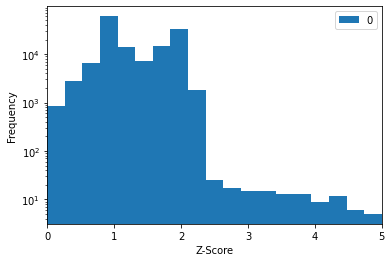

In [ ]:
max_zscore = pd.DataFrame(np.sort(stats.zscore(train_df)).max(axis=1))
plt = max_zscore.plot.hist(xlim=(0, 5), logy=True, bins=np.linspace(0, 5, 20))
plt.set_xlabel('Z-Score')

We removed outliers from our training set by removing all points with a z-score greater than 3. 

In [ ]:
train_df = train_df[(np.abs(stats.zscore(train_df)) < 3).all(axis=1)]

train_df


,LATITUDE,LONGITUDE,DISCOVERY_TIME,FIRE_SIZE,LABEL,MONTH
id,,,,,,
1,33.813100,-85.104300,1115.0,1.17,4,1
2,32.201000,-82.498700,1600.0,0.07,2,1
3,32.509300,-81.708600,1215.0,4.40,4,1
5,33.166700,-116.634200,1330.0,5.00,2,1
6,31.275800,-83.755500,1500.0,3.20,3,1
...,...,...,...,...,...,...
285358,34.095891,-116.507868,1153.0,1.00,2,12
285359,34.556944,-83.397222,1300.0,1.80,3,12
285360,34.330000,-117.513056,922.0,0.10,2,12


Here, we separate the classification labels from the features. 

In [ ]:
features = ['LATITUDE', 'LONGITUDE', 'DISCOVERY_TIME', 'FIRE_SIZE', 'MONTH']

X_train = train_df.loc[:, features].values

Y_train = train_df.loc[:,['LABEL']].values.ravel()

# Training the Model

After testing several models, we chose to use the RandomForestClassifier with 500 decision trees and gini impurity. To reduce overfitting, we set a minimum number of 10 samples per leaf. 

In [ ]:
np.random.seed(1)

n_estimators = 500
clf = RandomForestClassifier(n_estimators = n_estimators, criterion = 'gini', min_samples_leaf=10)
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Relative importance of features, in order of [Latitude, Longitude, Discovery Time, Fire Size, Month]. 

In [ ]:
print(clf.feature_importances_)

[0.32120848 0.36005075 0.14437803 0.07924464 0.09511809]


# Formatting the Test Data

To predict the test data, we removed all of the features except for the ones we trained on. In addition, since we wanted to predict the labels of all the points in the test set, we filled all of the NaN values with the mean of that column rather than dropping them completely. 

In [ ]:
test_df = test_df.drop(columns=['STATE', 'FIPS_NAME', 'FIPS_CODE', 'SOURCE_REPORTING_UNIT_NAME']).fillna(test_df.mean())
test_df['MONTH'] = test_df['DATE'].str[5:7]
test_df = test_df.drop(columns=['DATE'])


We used our trained model to obtain the probability that each test point was a certain class. 

In [ ]:
test = test_df.loc[:, features].values

results = clf.predict_proba(test)

Finally, we outputted our results into a .csv file, listing the id of the fire followed by the probability that it was class 1, 2, 3, and 4. 

In [ ]:
f = open("output.csv", "w")
id_index = 285382
f.write("id,P1,P2,P3,P4\n")
for point in results:
  f.write("{id},{P1},{P2},{P3},{P4}\n".format(id = str(id_index), P1 = point[0], P2 = point[1], P3 = point[2], P4 = point[3]))
  id_index += 1
f.close()